# Week Twelve

In [28]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import losses


# Task:  Build an autoencoder model to improve the clarity of dental X-rays (denoise the X-rays.) using the dental panoramic dataset.

## Task A:

### 1. Load the Dental-Panaromic-Autoencoder.npz dataset using NumPy.load. 
#### Note: NPZ is a file format by NumPy that provides storage of array data using gzip compression.

In [29]:
data = np.load('./Dental-Panaromic-Autoencoder.npz')

print(data.files)

['x_train', 'y_train', 'x_test', 'y_test']


### 2. Extract x_train, y_train, x_test and y_test NumPy arrays from the dataset 

In [30]:

X_train = data['x_train']
X_test = data['x_test']

X_train.shape

(92, 256, 256, 3)

### 3. A noisy version of the data set will be created by applying random noise to each image.
#### ○With a noise factor of 0.2, add noise to the signal by multiplying the noise factor and random values from a normal distribution. 
#### ○Hint: noise_factor = 0.2
#### ○x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
#### ○x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)
#### ○Clip the signal values between 0 and 1.

In [31]:
noise_factor = 0.2
X_train_noisy = X_train + noise_factor * tf.random.normal(shape=X_train.shape)
X_test_noisy = X_test + noise_factor * tf.random.normal(shape=X_test.shape)

In [32]:
#Clip signal intensity between 0 and 1
X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_min=0.0, clip_value_max=1.0)
X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_min=0.0, clip_value_max=1.0)

In [47]:
# Ensure the images are of shape (num_images, height, width, channels)
if len(X_train.shape) == 3:  # If images are grayscale and missing channel dimension
    X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)
    X_train_noisy = np.expand_dims(X_train_noisy, axis=-1)
    X_test_noisy = np.expand_dims(X_test_noisy, axis=-1)

# Check the shape of the datasets
print(X_train.shape, X_test.shape, X_train_noisy.shape, X_test_noisy.shape)

(92, 256, 256, 3) (24, 256, 256, 3) (92, 256, 256, 3) (24, 256, 256, 3)


### 4. Plot the first 5 X-ray images from the original images. (x_train)

### 5. Plot the first 5 X-ray images from noise images. (x_train_noisy)

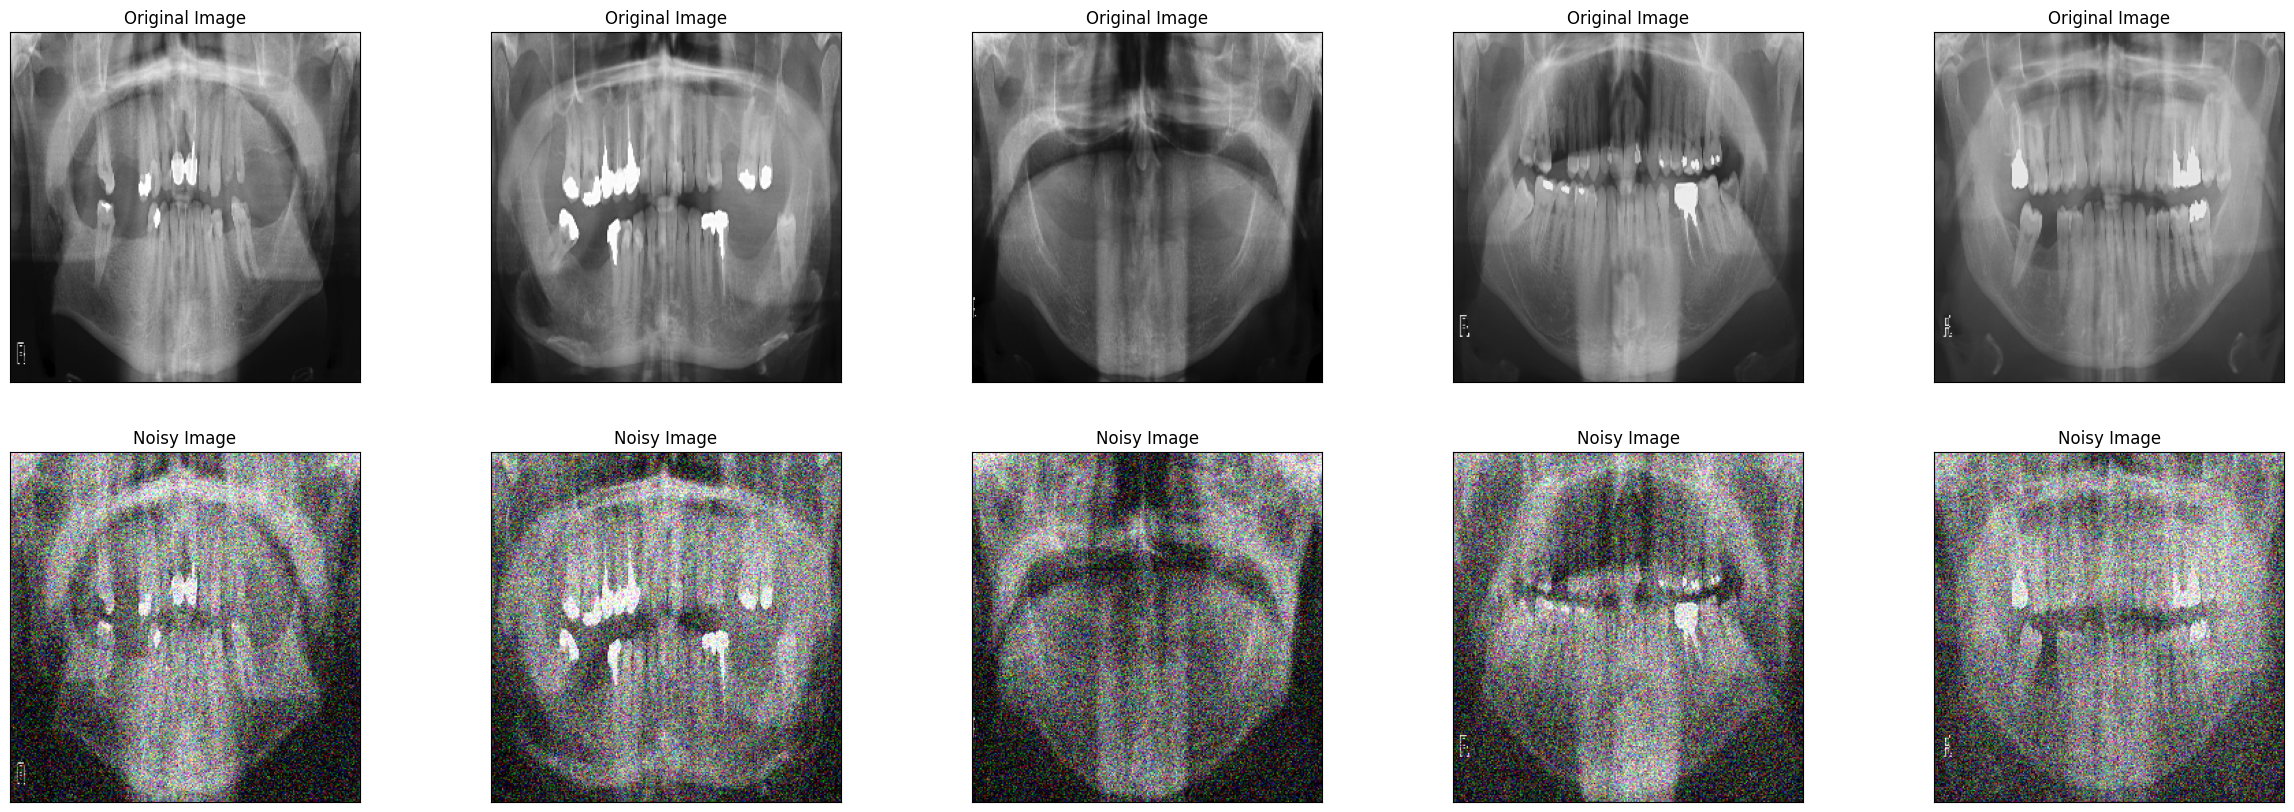

In [37]:

n = 5

plt.figure(figsize=(30, 10))

for i in range(n):

  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_train[i])
  plt.title("Original Image")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(X_train_noisy[i])
  plt.title("Noisy Image")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### 6. Train an autoencoder using the noisy image as the input and the original image as the destination. The images are shaped 256x256 in RGB scale
#### ○Create a Denoise class inherited from Keras Model 
#### ○The class has an encoder member variable of below layers
##### ■Input Layer of shape 256 * 256 * 3
##### ■Conv2D with 64 filters, kernel size 3,3, activation relu and same padding and strides 2
##### ■Conv2D with 32 filters, kernel size 3,3, activation relu and same padding and strides 2
#### ○The class has a decoder member variable of below layers
##### ■Conv2DTranspose with 32 filters, kernel size 3,3, activation relu and same padding and stride 2
##### ■Conv2DTranspose with 64 filters, kernel size 3,3, activation relu and same padding and stride 2
##### ■Conv2D with 1 filter, kernel size 3,3, activation sigmoid and same padding.

### 7. Create a call member function to the class which will pass the input to the encoder member function and the output of the encoder to the decoder member function.

In [48]:

class Denoise(tf.keras.Model):
    def __init__(self):
        super(Denoise, self).__init__()
        
        # Build the Encoder module
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(256,256,3)),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
        ])
        
        # Build the Decoder module
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=2),
            tf.keras.layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=2),
            tf.keras.layers.Conv2D(3, (3,3), activation='sigmoid', padding='same'),  # Output should have 3 channels (colors)
        ])
    
    def call(self, x):
        code = self.encoder(x)
        decoded = self.decoder(code)
        return decoded

### 8. Initialize the autoencoder object of the class Denoise

In [49]:
model = Denoise()

### 9. Compile the autoencoder with adam optimizer and MeanSquaredError as loss

In [50]:
# model.compile(optimizer='adam', loss='binary_crossentropy')
model.compile(optimizer='adam', 
              loss=losses.MeanSquaredError(), 
              metrics=['mae']) #mean absolute error


In [51]:
model.summary()

Model: "denoise_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ ?                      │        20,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,256 (79.12 KB)

 Trainable params: 20,256 (79.12 KB)

 Non-trainable params: 0 (0.00 B)

### 10. Train the autoencoder with X as x_train_noisy and Y as x_train for 50 epochs and validation data as x_test_noisy and x_test

In [ ]:
# # Split the dataset into training and validation sets
# from sklearn.model_selection import train_test_split

# x_train, x_val, y_train, y_val = train_test_split(X_train_noisy, X_train, test_size=0.2, random_state=42)


In [52]:
history = model.fit(X_train_noisy, 
                    X_train, 
                    epochs=50,
                    batch_size=32,
                    shuffle=True, 
                    validation_data=(X_test_noisy, X_test))

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - loss: 0.0537 - mae: 0.1847 - val_loss: 0.0523 - val_mae: 0.1821
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0508 - mae: 0.1798 - val_loss: 0.0514 - val_mae: 0.1810
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0518 - mae: 0.1822 - val_loss: 0.0500 - val_mae: 0.1792
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0485 - mae: 0.1763 - val_loss: 0.0478 - val_mae: 0.1761
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0462 - mae: 0.1727 - val_loss: 0.0441 - val_mae: 0.1699
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0431 - mae: 0.1678 - val_loss: 0.0379 - val_mae: 0.1580
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0348 - mae: 0.1506 - val_loss: 0.0278 - val_mae: 0.1338
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0244 - mae: 0.1232 - val_loss: 0.0148 - val_mae: 0.0911
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0122 - mae: 0.0805 - val_loss: 0.

### 11. Plot training and validation MAE and loss against epochs

In [53]:
history.history

{'loss': [0.053085461258888245,
  0.05227869004011154,
  0.05118532106280327,
  0.049331508576869965,
  0.04645613953471184,
  0.04184729978442192,
  0.03406500443816185,
  0.02289811708033085,
  0.010954583063721657,
  0.00758748035877943,
  0.009465624578297138,
  0.0070216297172009945,
  0.0051751164719462395,
  0.005172459874302149,
  0.004942117724567652,
  0.004232262261211872,
  0.003908482845872641,
  0.003858207957819104,
  0.0036297771148383617,
  0.003489572089165449,
  0.0033176986034959555,
  0.0032716956920921803,
  0.0031121610663831234,
  0.003019435331225395,
  0.002937076846137643,
  0.002872310345992446,
  0.002794477855786681,
  0.002733648754656315,
  0.0026886253617703915,
  0.0026295408606529236,
  0.002576701110228896,
  0.0025269673205912113,
  0.0024823076091706753,
  0.0024761680979281664,
  0.0024246778339147568,
  0.0024022350553423166,
  0.002335125580430031,
  0.002306158421561122,
  0.0023015241604298353,
  0.002361685736104846,
  0.0022872311528772116,


In [54]:
train_mae = history.history['mae']
val_mae = history.history['val_mae']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

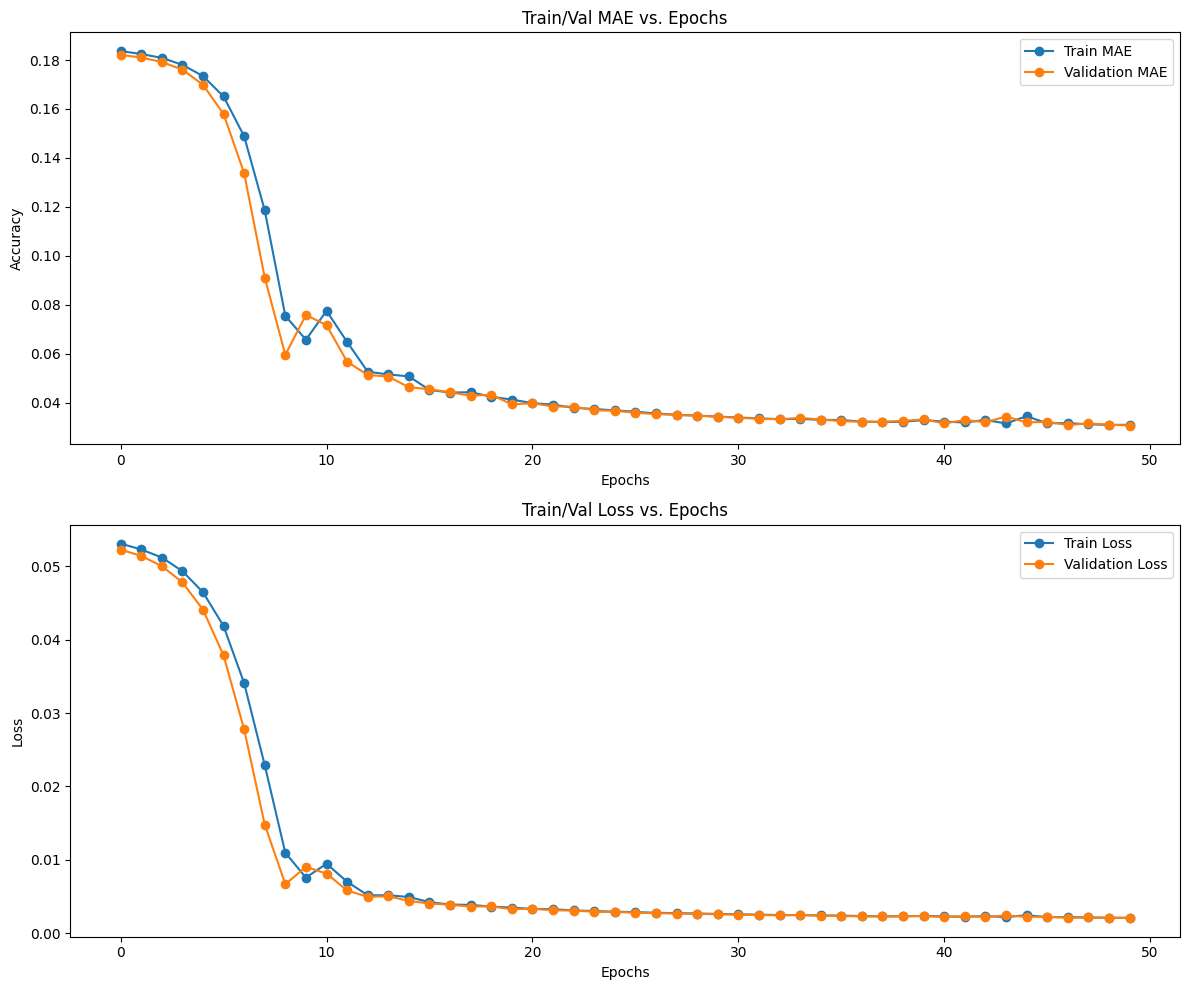

In [55]:
fix, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Train/Val MAE vs. Epochs')
ax[0].plot(train_mae, 'o-', label='Train MAE')
ax[0].plot(val_mae, 'o-', label='Validation MAE')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')


ax[1].set_title('Train/Val Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')


plt.tight_layout()
plt.show()

## Task B:

### 1. Evaluate the autoencoder model on x_test. 
#### ○Pass the x_test into the encoder
#### ○Pass the encoded images into the decoder. This step gives the decoded images that are reconstructed from the original.
##### Plot both the first 10 noisy images (x_test_noisy) and images without noise produced by the autoencoder. Check how well the AutoEncoder model has done the job with denoising.

In [56]:
# Predict the denoised images from noisy data
encoded_images = model.encoder(X_test_noisy).numpy()
decoded_images = model.decoder(encoded_images).numpy()

In [58]:
# # Predict the denoised images from noisy data
# decoded_images = model.predict(X_test_noisy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step


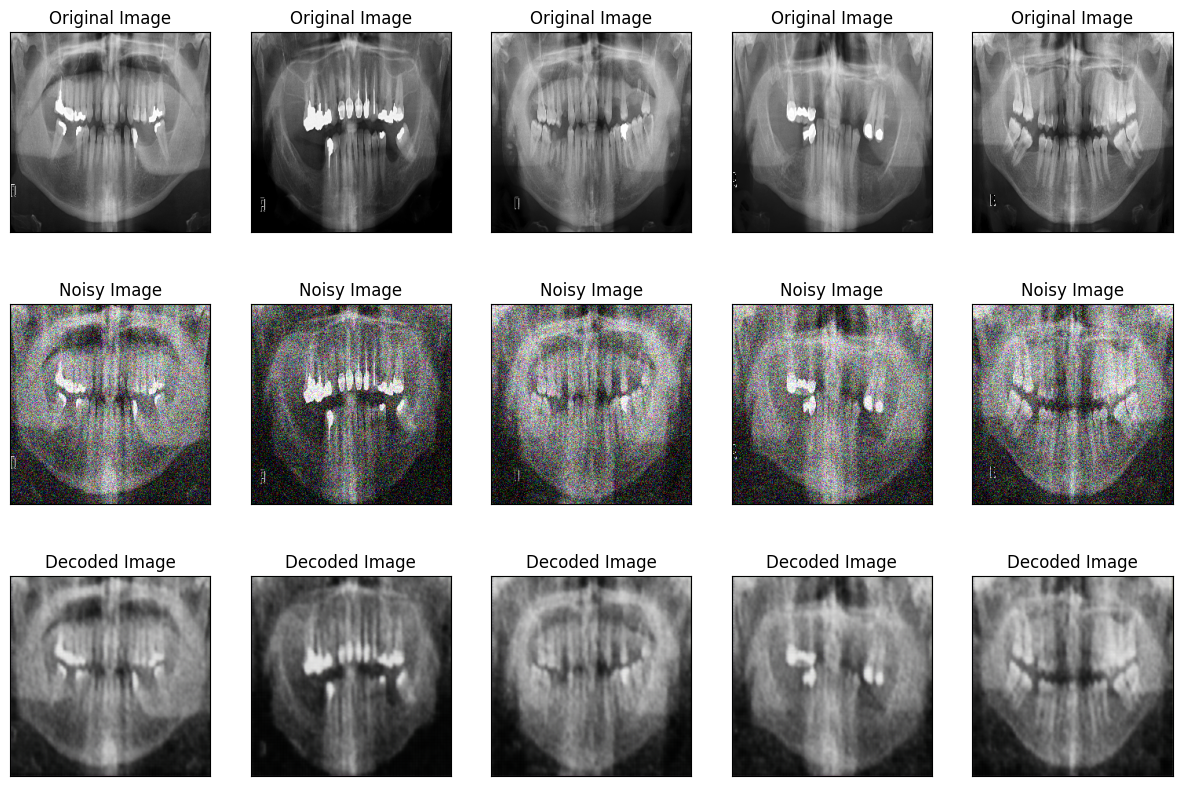

In [60]:

n = 5

plt.figure(figsize=(15, 10))
# plt.figure(figsize=(20, 4))

for i in range(n):

  ax = plt.subplot(3, n, i + 1)
  plt.imshow(X_test[i])
  plt.title("Original Image")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


  ax = plt.subplot(3, n, i + 1 + n)
  plt.imshow(X_test_noisy[i])
  plt.title("Noisy Image")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


  ax = plt.subplot(3, n, i + 1 + (2*n))
  plt.imshow(decoded_images[i])
  plt.title("Decoded Image")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()